In [5]:
import geopandas as gpd

# Load the GeoJSON data
geojson_path = '/data/private/BreizhCrops/experiments/training_results/main/0-baseline/0-baseline_model_accuracies.geojson'
gdfM = gpd.read_file(geojson_path)
print(gdfM.head())

        id CODE_CULTU                   path     meanCLD  sequencelength  \
0  5767259        LUZ  csv/frh01/5767259.csv  756.651308              50   
1  6017304        BTA  csv/frh01/6017304.csv  737.280000              50   
2  6017310        CZH  csv/frh01/6017310.csv  710.327555              50   
3  6017311        BTH  csv/frh01/6017311.csv  717.753189              50   
4  6017312        PPR  csv/frh01/6017312.csv  696.743646              50   

   classid      classname region          area   perimeter  \
0        3         fodder  frh01   9413.269572  414.933542   
1        5  miscellaneous  frh01   1665.638609  184.212032   
2       10       rapeseed  frh01  41233.158559  836.705857   
3        1   common wheat  frh01  34646.521324  754.644773   
4        9  protein crops  frh01  31913.064203  802.174602   

   area_perimeter_ratio  distance_to_closest_city  Field_ID  True_Label  \
0             22.686210              17157.706374   5767259           3   
1              9.041

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Best Threshold Area (F1): 6170.00 (R^2: 0.67)


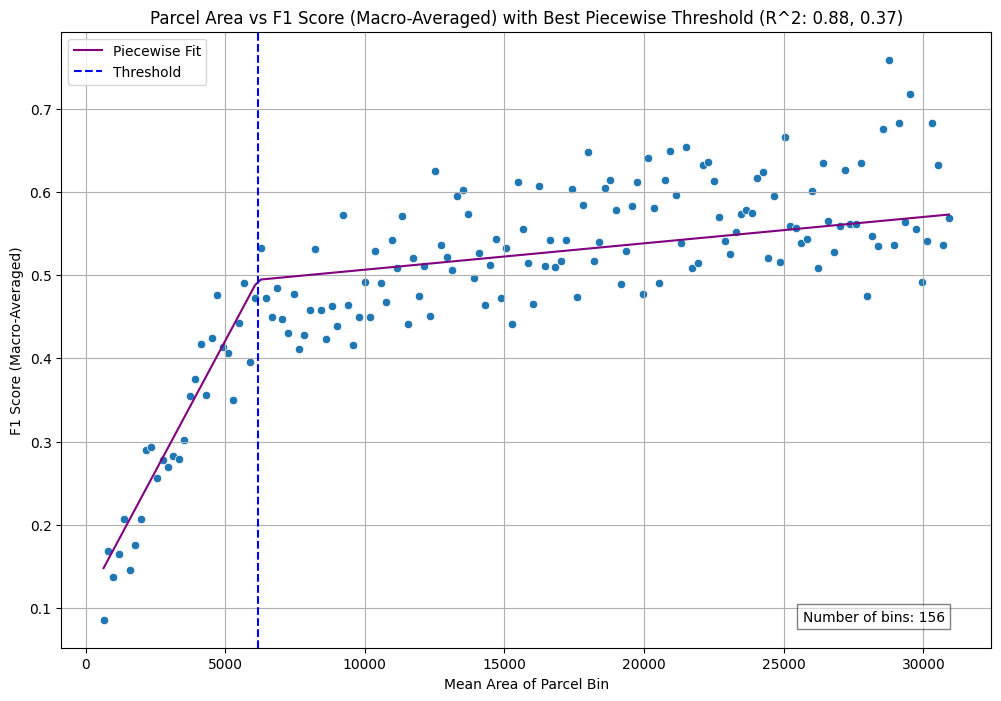

In [7]:
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score

# Function to model a two-segment linear piecewise function
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1 * x + y0 - k1 * x0,
                                      lambda x: k2 * x + y0 - k2 * x0])

# Residuals function to minimize
def residuals(params, x, y):
    x0, y0, k1, k2 = params
    return piecewise_linear(x, x0, y0, k1, k2) - y

# Assuming gdfM is a GeoDataFrame with necessary columns
gdf = gdfM
# Filter by region attribute 'frh04'
gdf = gdf.loc[gdf['region'] == 'frh04']

# Convert area to numeric, assuming 'area' column holds parcel areas
gdf['area'] = pd.to_numeric(gdf['area'], errors='coerce')

# Remove parcels with missing or invalid areas
gdf = gdf.dropna(subset=['area'])

# Define the range of cutoffs
cutoffs = np.arange(100000, 30000, -1000)

# Initialize variables to store the best threshold
best_cutoff_f1 = None
best_r2_f1 = -np.inf
best_p_opt_f1 = None

# Function to fit the piecewise linear model with constraints
def fit_piecewise_model_constrained(x_data, y_data, initial_guess, bounds):
    result = least_squares(residuals, initial_guess, args=(x_data, y_data), bounds=bounds)
    x0, y0, k1, k2 = result.x
    return x0, result.x

# Function to calculate R-squared for each segment
def calculate_r_squared(x_data, y_data, x0, params):
    mask1 = x_data < x0
    mask2 = ~mask1
    y_pred1 = piecewise_linear(x_data[mask1], *params)
    y_pred2 = piecewise_linear(x_data[mask2], *params)
    ss_res1 = np.sum((y_data[mask1] - y_pred1)**2)
    ss_res2 = np.sum((y_data[mask2] - y_pred2)**2)
    ss_tot1 = np.sum((y_data[mask1] - np.mean(y_data[mask1]))**2)
    ss_tot2 = np.sum((y_data[mask2] - np.mean(y_data[mask2]))**2)
    r2_1 = 1 - ss_res1 / ss_tot1
    r2_2 = 1 - ss_res2 / ss_tot2
    return r2_1, r2_2

# Iterate through each cutoff
for cutoff in cutoffs:
    # Filter data within the current cutoff range
    gdf_cutoff = gdf.loc[gdf['area'] <= cutoff]
    
    # Calculate the number of bins based on the square root choice within the cutoff bounds
    num_bins = int(np.ceil(np.sqrt(len(gdf_cutoff))))
    
    gdf_cutoff['area_bin'] = pd.cut(gdf_cutoff['area'], bins=num_bins)

    # Calculate statistics for each bin
    bin_stats = gdf_cutoff.groupby('area_bin').agg({
        'area': 'mean',
        'True_Label': lambda x: list(x),  # Correct true labels
        'Predicted_Label': lambda x: list(x)
    })
    bin_stats.columns = ['mean_area', 'true_labels', 'predicted_labels']
    
    # Initialize F1 score for each bin
    f1_scores = []
    
    # Calculate F1 score for each bin using sklearn f1_score (macro-averaged)
    for index, row in bin_stats.iterrows():
        true_labels = row['true_labels']
        predicted_labels = row['predicted_labels']
        
        if len(true_labels) > 0 and len(predicted_labels) > 0:
            f1 = f1_score(true_labels, predicted_labels, average='macro')
            f1_scores.append(f1)
        else:
            f1_scores.append(np.nan)
    
    # Store the calculated F1 scores in bin_stats
    bin_stats['f1'] = f1_scores

    # Remove bins with NaN F1 scores
    bin_stats.dropna(subset=['f1'], inplace=True)
    bin_stats = bin_stats.reset_index(drop=True)

    # Fit the piecewise linear model for F1 score
    x_data_f1 = bin_stats['mean_area'].values
    y_data_f1 = bin_stats['f1'].values
    initial_guess = [cutoff / 2, 0.5, 0.00001, 0.00001]
    bounds = ([0, 0, -np.inf, -np.inf], [cutoff, 1, np.inf, np.inf])
    
    try:
        x0_f1, p_opt_f1 = fit_piecewise_model_constrained(x_data_f1, y_data_f1, initial_guess, bounds)
        r2_f1_1, r2_f1_2 = calculate_r_squared(x_data_f1, y_data_f1, x0_f1, p_opt_f1)
        avg_r2_f1 = (r2_f1_1 + r2_f1_2) / 2
        if avg_r2_f1 > best_r2_f1:
            best_r2_f1 = avg_r2_f1
            best_cutoff_f1 = x0_f1
            best_p_opt_f1 = p_opt_f1
    except:
        continue

# Print the calculated threshold for F1 score
print(f"Best Threshold Area (F1): {best_cutoff_f1:.2f} (R^2: {best_r2_f1:.2f})")

# Plot the results for F1 score
plt.figure(figsize=(12, 8))
sns.scatterplot(x='mean_area', y='f1', data=bin_stats)
plt.plot(x_data_f1, piecewise_linear(x_data_f1, *best_p_opt_f1), color='purple', label='Piecewise Fit')
plt.axvline(x=best_cutoff_f1, color='blue', linestyle='--', label='Threshold')
plt.xlabel('Mean Area of Parcel Bin')
plt.ylabel('F1 Score (Macro-Averaged)')
plt.title(f'Parcel Area vs F1 Score (Macro-Averaged) with Best Piecewise Threshold (R^2: {r2_f1_1:.2f}, {r2_f1_2:.2f})')
plt.text(0.95, 0.05, f'Number of bins: {num_bins}', horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.grid(True)

# Save the plot as an SVG file
plt.savefig('/data/private/BreizhCrops/experiments/area_threshold/parcel_area_vs_f1_score.svg', format='svg')

plt.show()
